In [36]:
import os
import json
import requests
from datetime import datetime, timedelta, timezone
import pytz
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from dotenv import load_dotenv

In [2]:
# helper functions
def get_key():
    "Get the API key from an .env file"
    if ".env" not in os.listdir("../"):
        print("Configuring API Key...")
        key = input("Amberdata API Key: ")
        with open("../.env", "w") as f:
            f.write(f"AMBERDATA_API_KEY={key}\n")
    load_dotenv(verbose=True)
    return {
        "AMBERDATA_API_KEY": os.getenv("AMBERDATA_API_KEY")
    }

def get_response(url, headers=None, queryString=None):
    "Get the REST response from the specified URL"
    if not headers:
        headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}
    if queryString:
        response = requests.request("GET", url, headers=headers, params=queryString)
    else:
        response = requests.request("GET", url, headers=headers)
    response = json.loads(response.text)
    try:
        if response["title"] == "OK":
            return response["payload"]
    except Exception as e:
        print(e)
        return None
    
api_key = get_key()

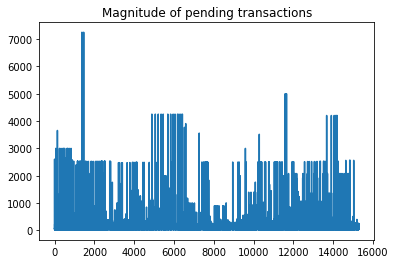

In [3]:
# read in the data from different sources
res1 = pd.read_csv("../data/results_07-08.csv", sep='; ', engine='python')
res2 = pd.read_csv("../data/results_10-12.csv", sep='; ', engine='python')

# join the different data files
results_all = pd.concat([res1, res2])

# get the value of BTC per pending txn
results_all["btc"] = results_all.value // 10**8

# plot just to see if there are lots of whale activity
results_all.btc.plot()
plt.title("Magnitude of pending transactions")
plt.show()

In [82]:
dfs = []
n_days = 7

for i in range(n_days):
    print(f"Iteration: {i}")
    # get the start and end dates in timestamps
    startDate = results_all.timestamp.min() + timedelta(i-1)
    endDate = startDate + timedelta(1)
    
    # convert to UNIX format
    startDate = str(round(startDate.timestamp()*10**3))
    endDate = str(round(endDate.timestamp()*10**3))

    # the url for our endpoint
    url = "https://web3api.io/api/v2/market/ohlcv/btc_usd/historical"
    
    # our query
    querystring = {
        "timeInterval": "minutes", 
        "timeFormat": "iso",
        'startDate': startDate, 
        'endDate': endDate, 
        "exchange": "bitfinex"
    }
    
    # the API key
    headers = {'x-api-key': api_key["AMBERDATA_API_KEY"]}

    # the response for our query
    payload = get_response(url, headers, querystring)
    
    # we save the OHLCV data
    bfx = payload['data']['bitfinex']

    # get the columns and make a dataframe
    columns = payload['metadata']['columns']
    bfx_df = pd.DataFrame(bfx, columns=columns)
    # append the dataframe to a list
    dfs.append(bfx_df)

# combine the several days of OHLCV data
ohlcv = pd.concat(dfs)

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


In [83]:
# save current data to csv
ohlcv.to_csv("../data/ohlcv.csv", index=False)
results_all.to_csv("../data/results_all.csv", index=False)

## Working with the OHLCV data

In [101]:
# read the data from our saved csvs
ohlcv = pd.read_csv("../data/ohlcv.csv")
results_all = pd.read_csv("../data/results_all.csv")

# change the UNIX timestamp to human readable format and set it as index
results_all["timestamp"] = pd.to_datetime(results_all.timestamp, utc=True)
# unify the timestamp format and set as index
ohlcv["timestamp"] = pd.to_datetime(ohlcv.timestamp)

In [102]:
# drop OHL from the dataframe
ohlcv.drop(['open', 'high', 'low'], axis=1, inplace=True)

# select only data from our date range
ohlcv = ohlcv[ohlcv.timestamp <= results_all.timestamp.max()]
ohlcv = ohlcv[ohlcv.timestamp >= results_all.timestamp.min()]

### Adding USD to Pending txns
We would like to add the value of Bitcoin to our results DataFrame, so we can see the value of the transactions in USD.

In [103]:
# add a column of timestamps rounded to the minute
results_all["ts_minute"] = results_all.timestamp.dt.round('1min')

# rename the ohlcv column for joining
ohlcv_min = ohlcv.rename({"timestamp": "ts_minute"}, axis=1)

# join the close column to the results dataframe
df_merged = pd.merge(results_all, ohlcv_min, on = "ts_minute", how='left').dropna()

# create the usd value column
df_merged["usd"] = df_merged.value/10**8 * df_merged.close

# display the result, sorted by the largest transactions
n_txn = 10       # the number of the top transactions we want to focus on

data_sorted = df_merged.sort_values("usd", ascending=False)
data_sorted.head(n_txn)

,timestamp,address,value,btc,ts_minute,close,volume,usd
2723,2020-08-10 17:59:43.711322+00:00,"['15ZvUtAydQGgWWwownPEQddg2xtnrrNVM7', '15ZvUt...",725000008214,7250,2020-08-10 18:00:00+00:00,11888.658444,0.051456,8.619277e+07
6408,2020-08-11 08:00:09.165819+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 08:00:00+00:00,11767.000000,7.768456,5.005675e+07
6698,2020-08-11 08:50:47.789672+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 08:51:00+00:00,11746.000000,0.517000,4.996742e+07
6236,2020-08-11 07:41:13.020856+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 07:41:00+00:00,11731.210618,0.345565,4.990451e+07
7399,2020-08-11 10:30:52.655096+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 10:31:00+00:00,11719.972916,3.182119,4.985670e+07
7529,2020-08-11 10:40:52.628770+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 10:41:00+00:00,11712.000000,0.273444,4.982279e+07
7303,2020-08-11 10:19:33.374962+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 10:20:00+00:00,11701.169888,0.032201,4.977671e+07
15470,2020-08-12 12:21:24.910269+00:00,['34s3t43zpjYbMr1kJFL8ucASFCdWouNeUV'],420399445796,4203,2020-08-12 12:21:00+00:00,11468.772812,0.040200,4.821466e+07
15254,2020-08-12 11:49:06.665446+00:00,['34s3t43zpjYbMr1kJFL8ucASFCdWouNeUV'],420399445796,4203,2020-08-12 11:49:00+00:00,11451.000000,13.154966,4.813994e+07
7936,2020-08-11 12:26:36.631267+00:00,"['18THhh4XC9mw41khhKcdkxxme4rKVTM3Yc', '18THhh...",390624459115,3906,2020-08-11 12:27:00+00:00,11692.000000,3.811354,4.567181e+07


## Plotting whale activity on price

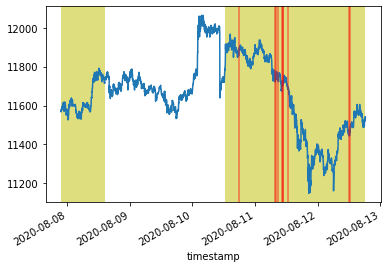

In [104]:
# plotting the time series of bitcoin price
ohlcv.set_index("timestamp", inplace=True)
ohlcv.close.plot()

# add a red line when a large pending transaction occured
for i in range(n_txn):
    plt.axvline(data_sorted.iloc[i, 0], color='r', alpha=0.5)

# get the periods we collected data
a1, b1 = res1.timestamp.min(), res1.timestamp.max()
a2, b2 = res2.timestamp.min(), res2.timestamp.max()

# display the collection periods
plt.axvspan(a1, b1, color='y', alpha=0.5, lw=0)
plt.axvspan(a2, b2, color='y', alpha=0.5, lw=0)
plt.show()

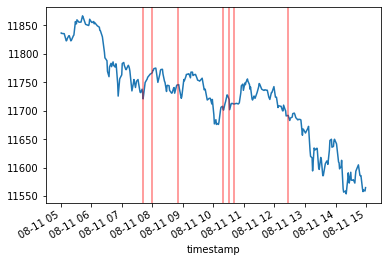

In [105]:
start, end = datetime(2020, 8, 11, 5, 0, 0, tzinfo=pytz.UTC), datetime(2020, 8, 11, 15, 0, 0, tzinfo=pytz.UTC)

ohlcv[(ohlcv.index > start) & (ohlcv.index < end)].close.plot()

for i in range(n_txn):
    ts = data_sorted.iloc[i, 0]
    if ts > start and ts < end:
        plt.axvline(ts, color='r', alpha=0.5)

In [110]:
data_sorted[(data_sorted.timestamp > start) & (data_sorted.timestamp < end)].iloc[:n_txn]

,timestamp,address,value,btc,ts_minute,close,volume,usd
6408,2020-08-11 08:00:09.165819+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 08:00:00+00:00,11767.000000,7.768456,5.005675e+07
6698,2020-08-11 08:50:47.789672+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 08:51:00+00:00,11746.000000,0.517000,4.996742e+07
6236,2020-08-11 07:41:13.020856+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 07:41:00+00:00,11731.210618,0.345565,4.990451e+07
7399,2020-08-11 10:30:52.655096+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 10:31:00+00:00,11719.972916,3.182119,4.985670e+07
7529,2020-08-11 10:40:52.628770+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 10:41:00+00:00,11712.000000,0.273444,4.982279e+07
7303,2020-08-11 10:19:33.374962+00:00,['3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'],425399464402,4253,2020-08-11 10:20:00+00:00,11701.169888,0.032201,4.977671e+07
7936,2020-08-11 12:26:36.631267+00:00,"['18THhh4XC9mw41khhKcdkxxme4rKVTM3Yc', '18THhh...",390624459115,3906,2020-08-11 12:27:00+00:00,11692.000000,3.811354,4.567181e+07
5481,2020-08-11 06:05:41.634805+00:00,"['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '38Bhu1...",249865660844,2498,2020-08-11 06:06:00+00:00,11853.000000,2.860961,2.961658e+07
5335,2020-08-11 05:32:07.739696+00:00,"['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6', '35mKzn...",249182614944,2491,2020-08-11 05:32:00+00:00,11860.000000,0.366635,2.955306e+07
5784,2020-08-11 07:00:04.925181+00:00,['19iqYbeATe4RxghQZJnYVFU4mjUUu76EA6'],248865074274,2488,2020-08-11 07:00:00+00:00,11763.173887,2.008001,2.927443e+07


In [120]:
address = '3CpB9Wypwon6EvEDbDXS76U1xGCrtM6pQM'

url = f"https://web3api.io/api/v2/addresses/{address}/transactions"

querystring = {
    "startDate": str(int(datetime(2020, 8, 11).timestamp())), 
    "endDate": str(int(datetime.today().timestamp())),
    "page":"0","size":"2"
}

headers = {
    'x-amberdata-blockchain-id': "bitcoin-mainnet",
    'x-api-key': "API_KEY"
}

get_response(url, headers, querystring)

'title'


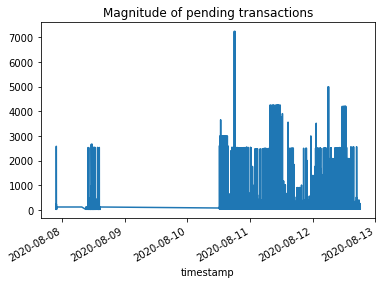

In [99]:
results_all.set_index("timestamp").btc.plot()
plt.title("Magnitude of pending transactions")
plt.show()